In [1]:
import os
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
#from .utils import load_state_dict_from_url


# for testing only
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import os
from PIL import Image
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from PIL import Image
from tqdm import tqdm

import pandas as pd 
import numpy as np
from matplotlib.pyplot import imshow

from copy import deepcopy
import torchvision.utils as vutils
from torch.autograd import Variable

# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)


In [2]:
!pip3 install tqdm

In [3]:

# Data augmentation and converting to tensors
random_transforms = [transforms.ColorJitter(),transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize((64,64)),
                                # transforms.CenterCrop(64),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
%ls

 Il volume nell'unità C non ha etichetta.
 Numero di serie del volume: F0D7-F9D0

 Directory di C:\Users\isnob\Documents\workspace\doggo_gan

20/01/2020  11:31    <DIR>          .
20/01/2020  11:31    <DIR>          ..
20/01/2020  10:07    <DIR>          .ipynb_checkpoints
19/01/2020  19:31    <DIR>          dataset
20/01/2020  11:31           481.804 DOGGO_GAN.ipynb
20/01/2020  10:03    <DIR>          models
19/01/2020  19:28                15 README.md
               2 File        481.819 byte
               5 Directory  24.675.172.352 byte disponibili


In [5]:
if os.path.isdir('dataset'):
    root_dir='./'
else:
    root_dir='./doggo_gan/'
    # Clone github repository with data
    if not os.path.isdir('./doggo-gan'):
      !git clone 'https://gitlab.com/isnob46/doggo_gan.git'


In [6]:
print(root_dir)

./


In [7]:
import time
device='cuda'

def donetime(start=None):
  if start != None:
    if ((time.time() - start)/60) < 60:
      print('DONE (time {:4.2f} m)'.format((time.time() - start)/60))
    else:
      print('DONE (time {:4.2f} h)'.format((time.time() - start)/3600))
  else:
    print('\nDONE')
  return

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def show_batch_images(dataset,batch_size,title=''):
  fig, axs = plt.subplots(1, batch_size,figsize=(15, 3), dpi=80)
  for i in range(batch_size):
    n=randint(0,len(dataset))
    im,label=dataset[n]
    unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    im=unorm(im)
    axs[i].imshow(im.permute(1,2,0))
    axs[i].set_title(list(dataset.class_to_idx.keys())[label] )
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()
    
def show_batch_images(dataloader):
    # visualization batch image
    real_batch = iter(dataloader).next()
    plt.figure(figsize=(15,15))
    plt.axis("off")
    plt.title("Training Images")
    image = np.transpose(vutils.make_grid(real_batch[0].to(device), normalize=True).cpu(),axes=(1,2,0))
    plt.imshow(image)

loaded: 20580
classes: 120


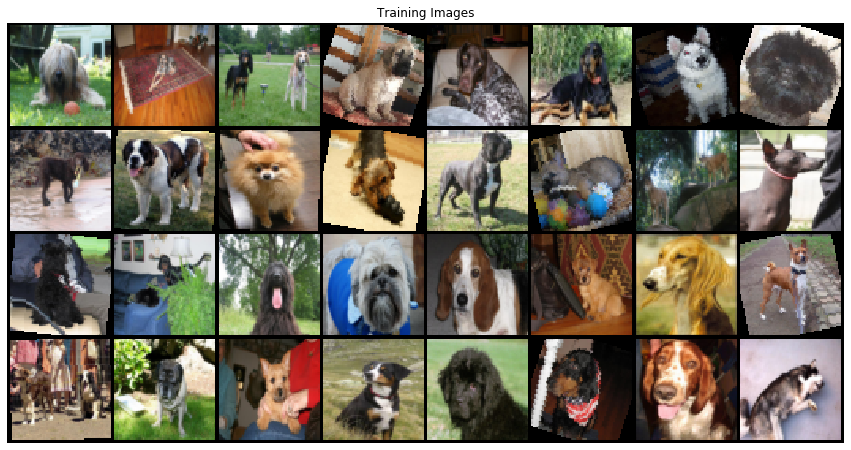

In [8]:
# This loader will use the underlying loader plus crop the image based on the annotation

def doggo_loader(path):
    img = torchvision.datasets.folder.default_loader(path) # default loader
    
    # Get bounding box
    annotation_basename = os.path.splitext(os.path.basename(path))[0]
    annotation_dirname = next(dirname for dirname in os.listdir(root_dir+'dataset/annotation/') if dirname.startswith(annotation_basename.split('_')[0]))
    annotation_filename = os.path.join(root_dir+'dataset/annotation/', annotation_dirname, annotation_basename)
    tree = ET.parse(annotation_filename)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    bbox = (xmin, ymin, xmax, ymax)
    
    # return cropped image
    return img.crop(bbox)
    #return img

dataset = torchvision.datasets.ImageFolder(
    root_dir+'dataset/images',
   # loader=doggo_loader, # THE CUSTOM LOADER
    transform=transform
)
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,batch_size=32)


print('loaded:',len(dataset))
print('classes:',len(dataset.classes))
show_batch_images(dataloader)



# GENERATOR AND DISCRIMINATOR

In [9]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)


In [10]:
BATCH_SIZE=32
EPOCH = 100 # play with me
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda")
LR = 0.001
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []
cudnn.benchmark
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,batch_size=BATCH_SIZE,num_workers=8)


In [11]:
def plot_loss(G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        
        unorm=UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        gen_image=unorm(gen_image)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize=(60, 60), dpi=80)
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
    plt.show()
    plt.close()

# TRAIN GAN

 50%|████▉     | 321/644 [00:20<00:20, 16.10it/s]

[1/100][322/644] Loss_D: 1.0490 Loss_G: 1.2925 D(x): 0.6256 D(G(z)): 0.3098 / 0.3098


100%|█████████▉| 643/644 [00:40<00:00, 17.19it/s]

[1/100][644/644] Loss_D: 1.3067 Loss_G: 1.5507 D(x): 0.3667 D(G(z)): 0.2192 / 0.2192


100%|██████████| 644/644 [00:40<00:00, 15.90it/s]


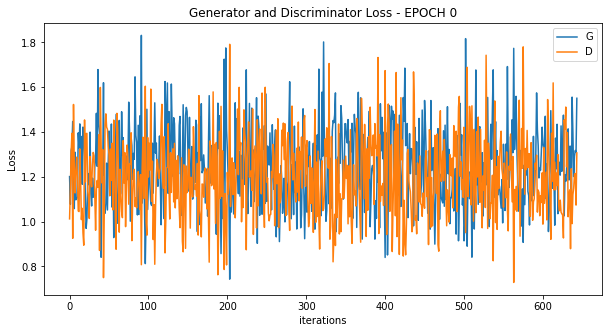

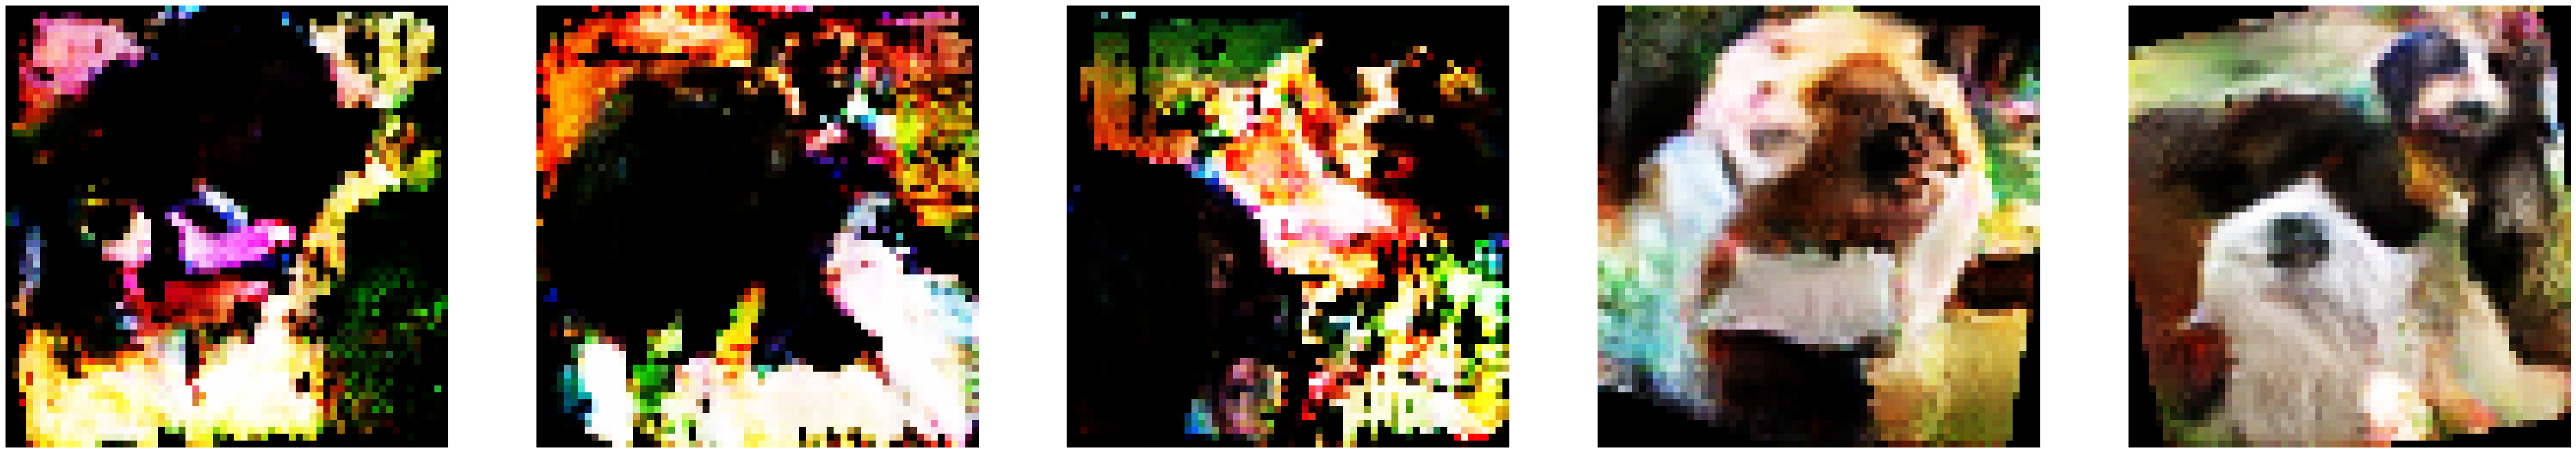

 50%|████▉     | 321/644 [00:19<00:19, 16.52it/s]

[2/100][322/644] Loss_D: 1.2583 Loss_G: 1.1796 D(x): 0.5907 D(G(z)): 0.3783 / 0.3783


100%|█████████▉| 643/644 [00:39<00:00, 16.53it/s]

[2/100][644/644] Loss_D: 1.4343 Loss_G: 3.0810 D(x): 0.3386 D(G(z)): 0.0489 / 0.0489


100%|██████████| 644/644 [00:39<00:00, 16.11it/s]


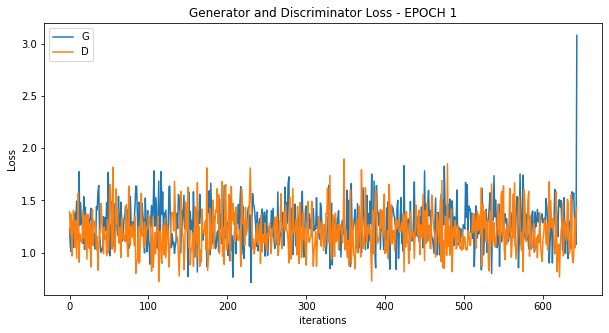

 50%|████▉     | 321/644 [00:19<00:19, 16.38it/s]

[3/100][322/644] Loss_D: 1.3764 Loss_G: 1.1662 D(x): 0.5274 D(G(z)): 0.3650 / 0.3650


100%|█████████▉| 643/644 [00:39<00:00, 17.01it/s]

[3/100][644/644] Loss_D: 1.2013 Loss_G: 1.9570 D(x): 0.4340 D(G(z)): 0.1245 / 0.1245


100%|██████████| 644/644 [00:39<00:00, 16.14it/s]


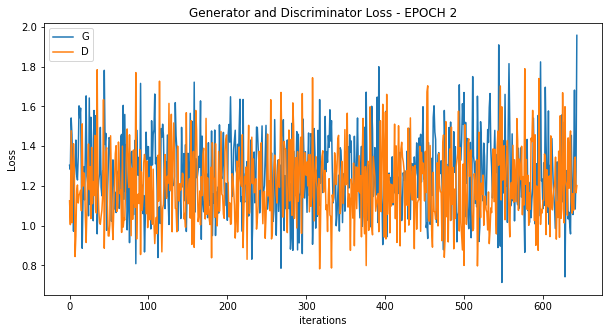

 50%|████▉     | 321/644 [00:19<00:19, 16.32it/s]

[4/100][322/644] Loss_D: 1.0777 Loss_G: 1.1310 D(x): 0.7285 D(G(z)): 0.3733 / 0.3733


100%|█████████▉| 643/644 [00:39<00:00, 16.65it/s]

[4/100][644/644] Loss_D: 1.5355 Loss_G: 4.6994 D(x): 0.2432 D(G(z)): 0.0098 / 0.0098


100%|██████████| 644/644 [00:39<00:00, 16.12it/s]


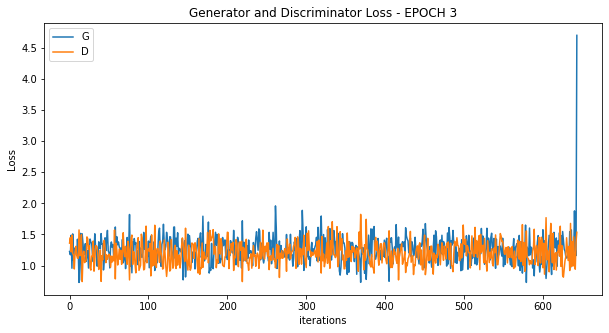

 50%|████▉     | 321/644 [00:20<00:20, 16.10it/s]

[5/100][322/644] Loss_D: 1.5342 Loss_G: 1.4582 D(x): 0.4033 D(G(z)): 0.3143 / 0.3143


100%|█████████▉| 643/644 [00:40<00:00, 16.60it/s]

[5/100][644/644] Loss_D: 0.5725 Loss_G: 2.6188 D(x): 0.7256 D(G(z)): 0.1311 / 0.1311


100%|██████████| 644/644 [00:40<00:00, 15.98it/s]


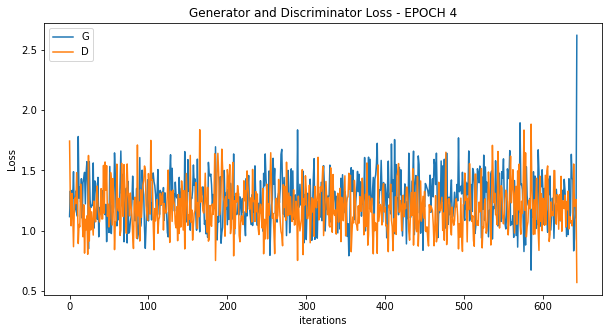

 50%|████▉     | 321/644 [00:20<00:19, 16.15it/s]

[6/100][322/644] Loss_D: 1.3673 Loss_G: 1.1042 D(x): 0.5451 D(G(z)): 0.3951 / 0.3951


100%|█████████▉| 643/644 [00:39<00:00, 17.11it/s]

[6/100][644/644] Loss_D: 1.9410 Loss_G: 1.5862 D(x): 0.2234 D(G(z)): 0.1786 / 0.1786


100%|██████████| 644/644 [00:40<00:00, 16.05it/s]


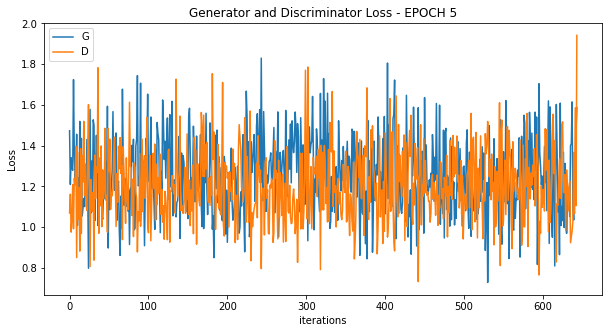

 50%|████▉     | 321/644 [00:20<00:19, 16.42it/s]

[7/100][322/644] Loss_D: 1.1910 Loss_G: 1.0067 D(x): 0.6611 D(G(z)): 0.4009 / 0.4009


100%|█████████▉| 643/644 [00:40<00:00, 16.67it/s]

[7/100][644/644] Loss_D: 0.6150 Loss_G: 1.6871 D(x): 0.9154 D(G(z)): 0.2101 / 0.2101


100%|██████████| 644/644 [00:40<00:00, 15.99it/s]


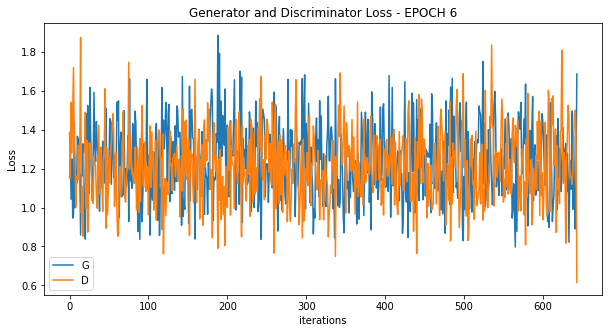

 50%|████▉     | 321/644 [00:20<00:19, 16.24it/s]

[8/100][322/644] Loss_D: 1.1968 Loss_G: 1.4422 D(x): 0.5236 D(G(z)): 0.2779 / 0.2779


100%|█████████▉| 643/644 [00:39<00:00, 17.00it/s]

[8/100][644/644] Loss_D: 1.4172 Loss_G: 2.3148 D(x): 0.3756 D(G(z)): 0.0949 / 0.0949


100%|██████████| 644/644 [00:40<00:00, 16.09it/s]


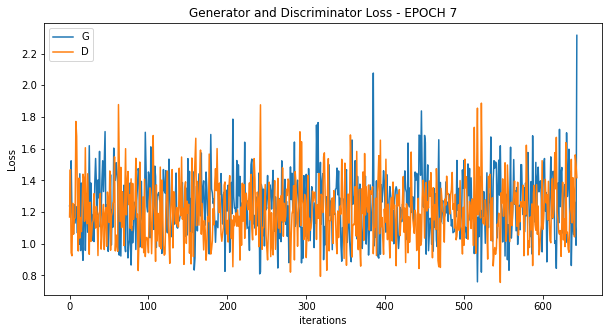

 50%|████▉     | 321/644 [00:19<00:19, 16.51it/s]

[9/100][322/644] Loss_D: 1.0264 Loss_G: 1.1435 D(x): 0.7308 D(G(z)): 0.3719 / 0.3719


100%|█████████▉| 643/644 [00:39<00:00, 17.03it/s]

[9/100][644/644] Loss_D: 1.4345 Loss_G: 2.6803 D(x): 0.3815 D(G(z)): 0.1327 / 0.1327


100%|██████████| 644/644 [00:39<00:00, 16.24it/s]


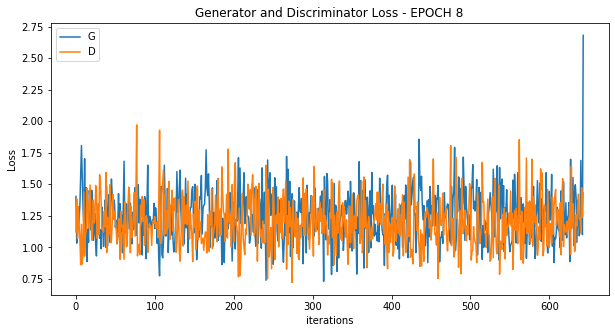

 50%|████▉     | 321/644 [00:20<00:19, 16.30it/s]

[10/100][322/644] Loss_D: 1.1053 Loss_G: 1.4031 D(x): 0.5897 D(G(z)): 0.2936 / 0.2936


100%|█████████▉| 643/644 [00:39<00:00, 17.02it/s]

[10/100][644/644] Loss_D: 1.5556 Loss_G: 2.8658 D(x): 0.3753 D(G(z)): 0.0668 / 0.0668


100%|██████████| 644/644 [00:39<00:00, 16.12it/s]


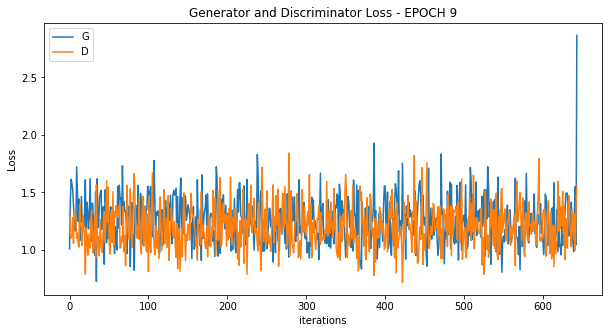

 50%|████▉     | 321/644 [00:19<00:20, 15.69it/s]

[11/100][322/644] Loss_D: 1.1362 Loss_G: 1.2369 D(x): 0.6311 D(G(z)): 0.3590 / 0.3590


100%|█████████▉| 643/644 [00:39<00:00, 17.00it/s]

[11/100][644/644] Loss_D: 1.1406 Loss_G: 1.8384 D(x): 0.5128 D(G(z)): 0.1585 / 0.1585


100%|██████████| 644/644 [00:40<00:00, 16.04it/s]


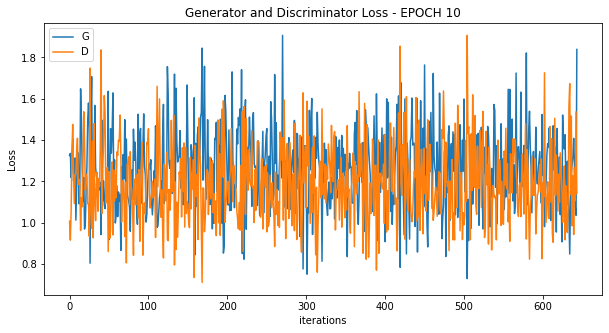

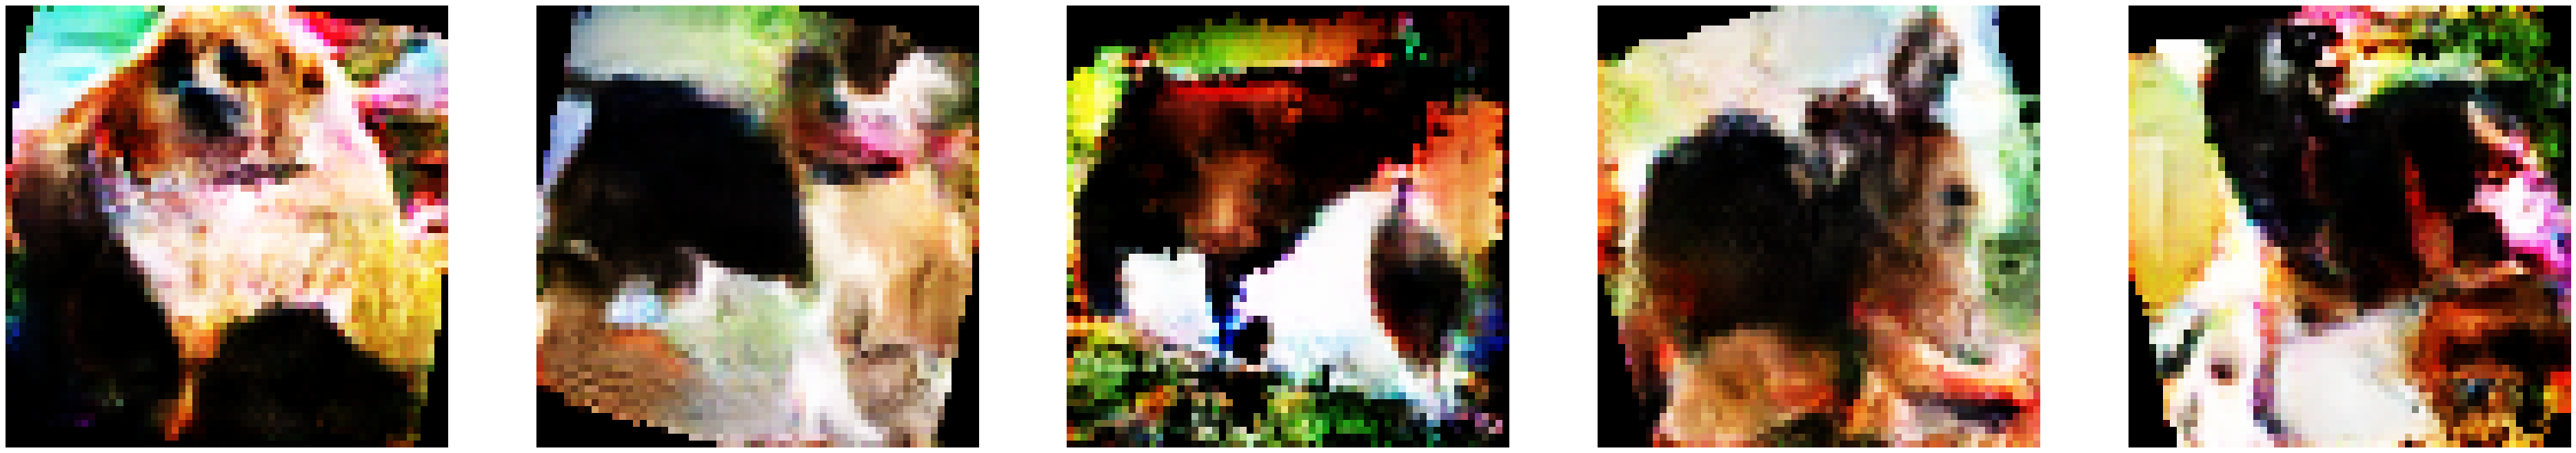

 50%|████▉     | 321/644 [00:20<00:19, 16.37it/s]

[12/100][322/644] Loss_D: 1.1837 Loss_G: 1.3566 D(x): 0.5726 D(G(z)): 0.3211 / 0.3211


100%|█████████▉| 643/644 [00:40<00:00, 16.84it/s]

[12/100][644/644] Loss_D: 1.1073 Loss_G: 2.0824 D(x): 0.4592 D(G(z)): 0.1359 / 0.1359


100%|██████████| 644/644 [00:40<00:00, 15.94it/s]


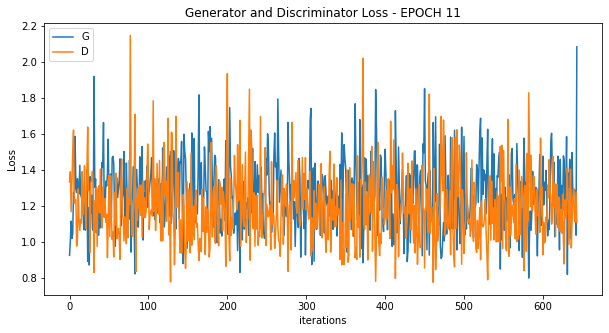

 50%|████▉     | 321/644 [00:19<00:19, 16.44it/s]

[13/100][322/644] Loss_D: 1.5015 Loss_G: 1.3343 D(x): 0.4758 D(G(z)): 0.3701 / 0.3701


100%|█████████▉| 643/644 [00:39<00:00, 16.88it/s]

[13/100][644/644] Loss_D: 0.7533 Loss_G: 1.7343 D(x): 0.6332 D(G(z)): 0.1780 / 0.1780


100%|██████████| 644/644 [00:39<00:00, 16.20it/s]


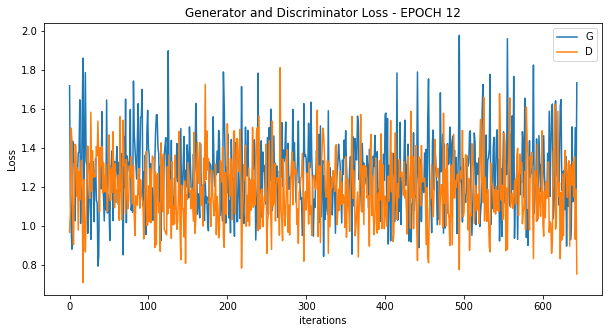

 50%|████▉     | 321/644 [00:20<00:19, 16.19it/s]

[14/100][322/644] Loss_D: 1.4185 Loss_G: 0.8806 D(x): 0.5811 D(G(z)): 0.4660 / 0.4660


100%|█████████▉| 643/644 [00:39<00:00, 16.92it/s]

[14/100][644/644] Loss_D: 1.5205 Loss_G: 1.0547 D(x): 0.5349 D(G(z)): 0.3621 / 0.3621


100%|██████████| 644/644 [00:40<00:00, 16.03it/s]


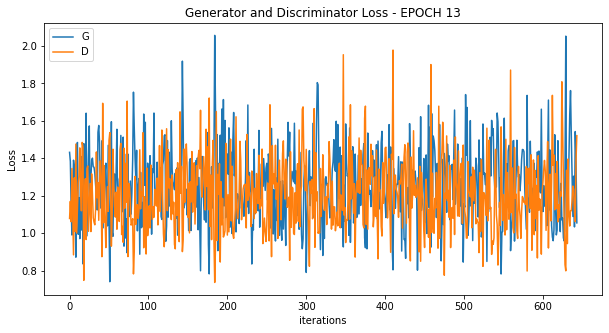

 50%|████▉     | 321/644 [00:20<00:20, 16.02it/s]

[15/100][322/644] Loss_D: 0.9514 Loss_G: 1.7051 D(x): 0.6744 D(G(z)): 0.2397 / 0.2397


100%|█████████▉| 643/644 [00:39<00:00, 17.27it/s]

[15/100][644/644] Loss_D: 0.5469 Loss_G: 2.3531 D(x): 0.7769 D(G(z)): 0.1195 / 0.1195


100%|██████████| 644/644 [00:39<00:00, 16.11it/s]


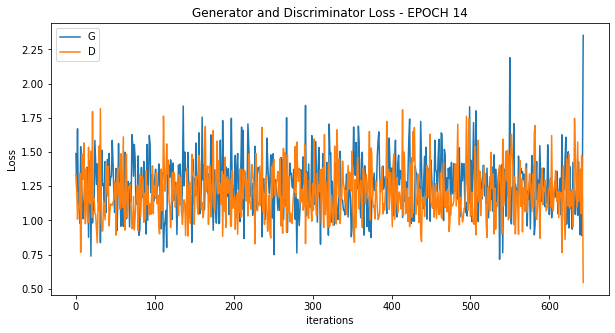

 50%|████▉     | 321/644 [00:19<00:19, 16.73it/s]

[16/100][322/644] Loss_D: 1.4381 Loss_G: 1.1109 D(x): 0.5375 D(G(z)): 0.3783 / 0.3783


100%|█████████▉| 643/644 [00:39<00:00, 17.31it/s]

[16/100][644/644] Loss_D: 0.7395 Loss_G: 2.1195 D(x): 0.6516 D(G(z)): 0.1560 / 0.1560


100%|██████████| 644/644 [00:39<00:00, 16.38it/s]


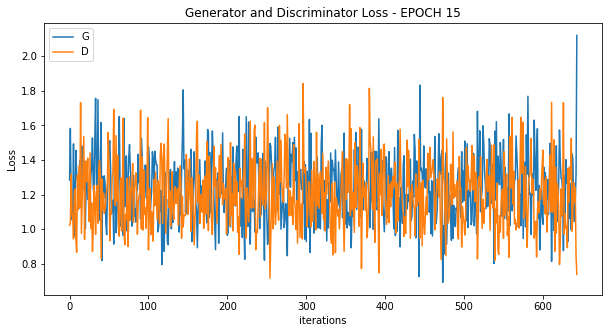

 50%|████▉     | 321/644 [00:19<00:19, 16.56it/s]

[17/100][322/644] Loss_D: 1.1714 Loss_G: 1.1719 D(x): 0.6135 D(G(z)): 0.3605 / 0.3605


100%|█████████▉| 643/644 [00:39<00:00, 17.43it/s]

[17/100][644/644] Loss_D: 1.3545 Loss_G: 2.4996 D(x): 0.2950 D(G(z)): 0.0801 / 0.0801


100%|██████████| 644/644 [00:39<00:00, 16.29it/s]


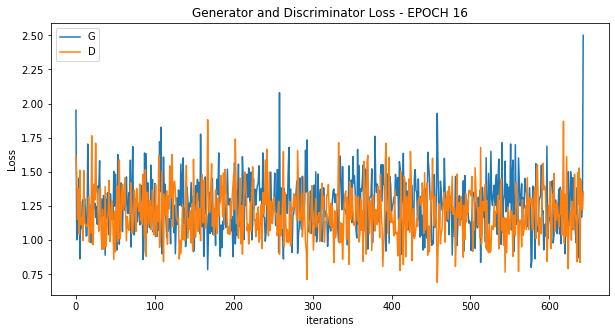

 50%|████▉     | 321/644 [00:19<00:19, 16.94it/s]

[18/100][322/644] Loss_D: 1.0396 Loss_G: 1.0997 D(x): 0.6850 D(G(z)): 0.3665 / 0.3665


100%|█████████▉| 643/644 [00:38<00:00, 17.47it/s]

[18/100][644/644] Loss_D: 1.3759 Loss_G: 2.7963 D(x): 0.4091 D(G(z)): 0.0582 / 0.0582


100%|██████████| 644/644 [00:39<00:00, 16.49it/s]


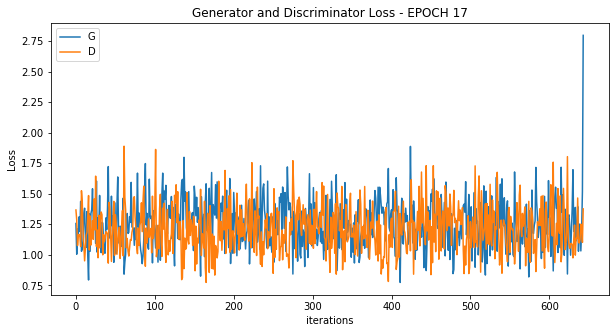

 50%|████▉     | 321/644 [00:19<00:19, 16.87it/s]

[19/100][322/644] Loss_D: 1.2177 Loss_G: 1.5350 D(x): 0.5057 D(G(z)): 0.2631 / 0.2631


100%|█████████▉| 643/644 [00:39<00:00, 16.69it/s]

[19/100][644/644] Loss_D: 0.6068 Loss_G: 2.8396 D(x): 0.8301 D(G(z)): 0.1452 / 0.1452


100%|██████████| 644/644 [00:39<00:00, 16.39it/s]


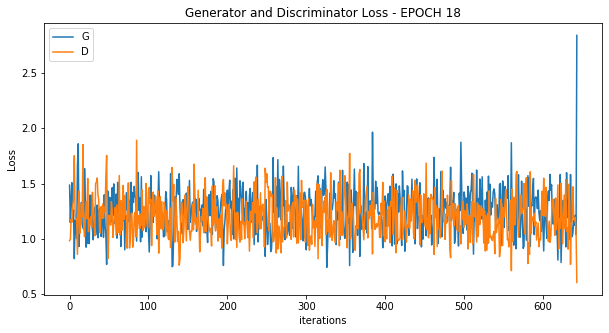

 50%|████▉     | 321/644 [00:19<00:19, 16.56it/s]

[20/100][322/644] Loss_D: 1.3065 Loss_G: 0.9938 D(x): 0.6405 D(G(z)): 0.4517 / 0.4517


100%|█████████▉| 643/644 [00:39<00:00, 16.83it/s]

[20/100][644/644] Loss_D: 0.4870 Loss_G: 2.3756 D(x): 0.8513 D(G(z)): 0.1154 / 0.1154


100%|██████████| 644/644 [00:39<00:00, 16.34it/s]


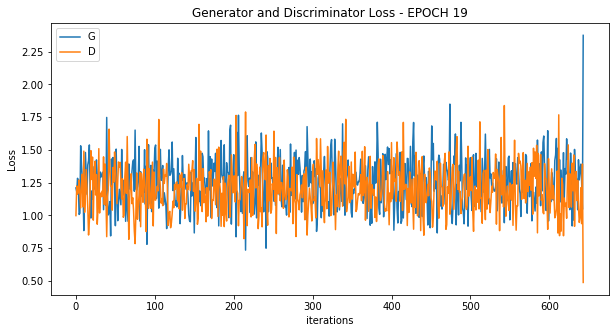

 50%|████▉     | 321/644 [00:19<00:19, 16.59it/s]

[21/100][322/644] Loss_D: 1.1435 Loss_G: 0.9880 D(x): 0.7568 D(G(z)): 0.4298 / 0.4298


100%|█████████▉| 643/644 [00:38<00:00, 17.45it/s]

[21/100][644/644] Loss_D: 1.2077 Loss_G: 1.9444 D(x): 0.4705 D(G(z)): 0.2212 / 0.2212


100%|██████████| 644/644 [00:39<00:00, 16.47it/s]


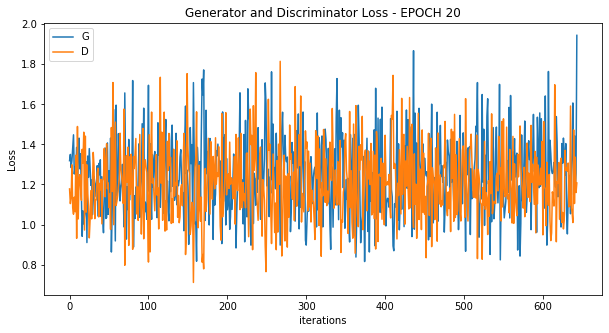

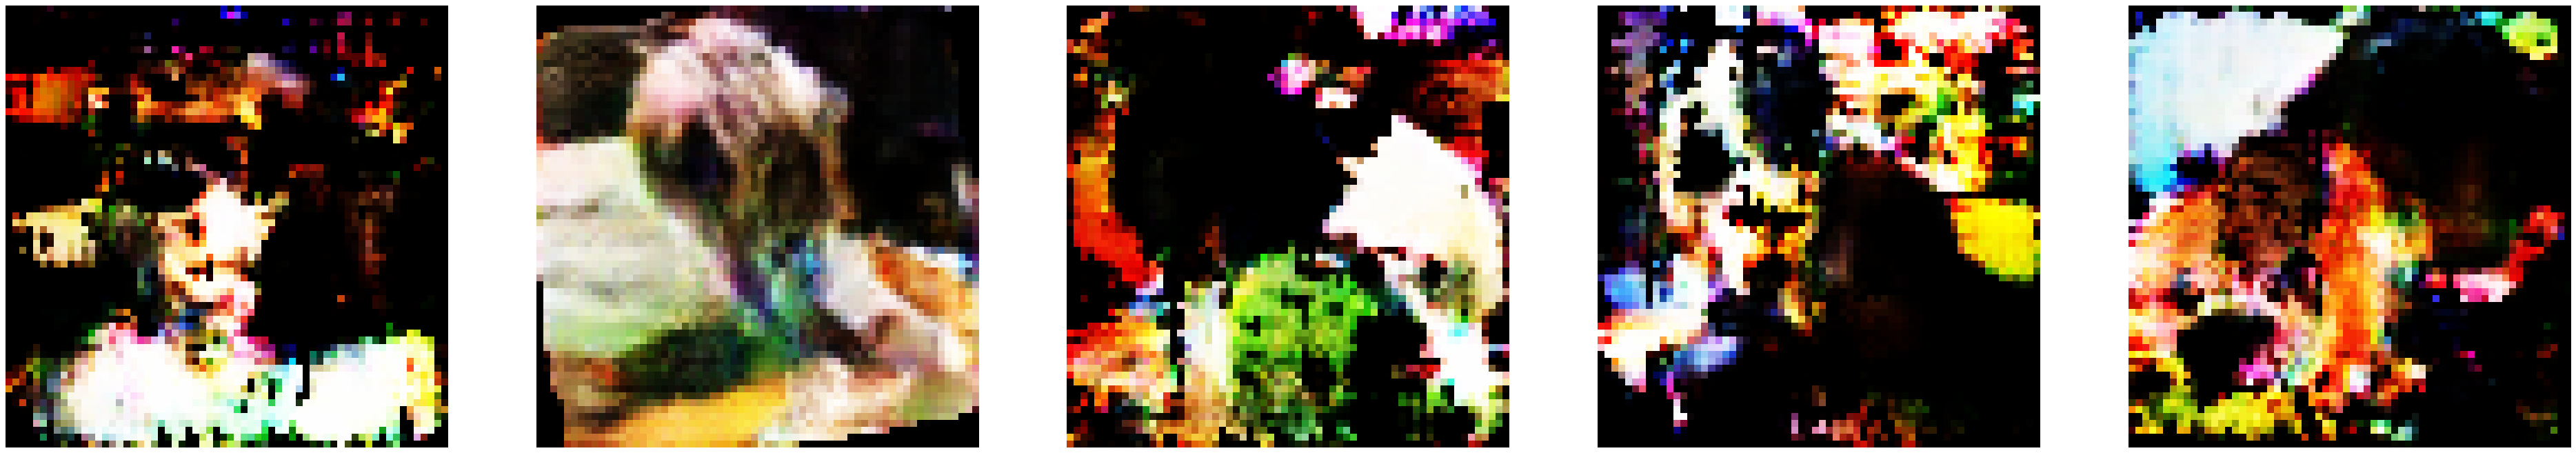

 50%|████▉     | 321/644 [00:19<00:20, 15.96it/s]

[22/100][322/644] Loss_D: 1.1894 Loss_G: 1.4839 D(x): 0.5388 D(G(z)): 0.2881 / 0.2881


100%|█████████▉| 643/644 [00:39<00:00, 15.96it/s]

[22/100][644/644] Loss_D: 0.8556 Loss_G: 2.2033 D(x): 0.4978 D(G(z)): 0.1167 / 0.1167


100%|██████████| 644/644 [00:39<00:00, 16.18it/s]


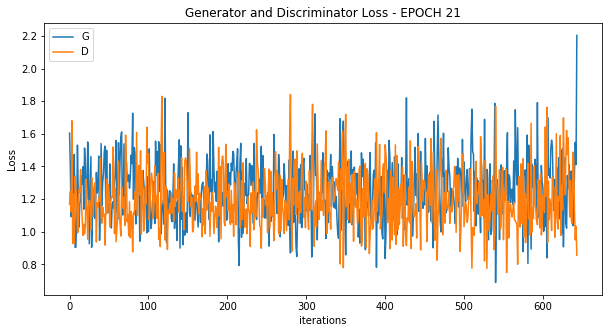

 50%|████▉     | 321/644 [00:20<00:19, 16.39it/s]

[23/100][322/644] Loss_D: 1.1021 Loss_G: 1.2521 D(x): 0.6485 D(G(z)): 0.3556 / 0.3556


100%|█████████▉| 643/644 [00:40<00:00, 17.38it/s]

[23/100][644/644] Loss_D: 1.0061 Loss_G: 1.6167 D(x): 0.5396 D(G(z)): 0.2511 / 0.2511


100%|██████████| 644/644 [00:40<00:00, 15.99it/s]


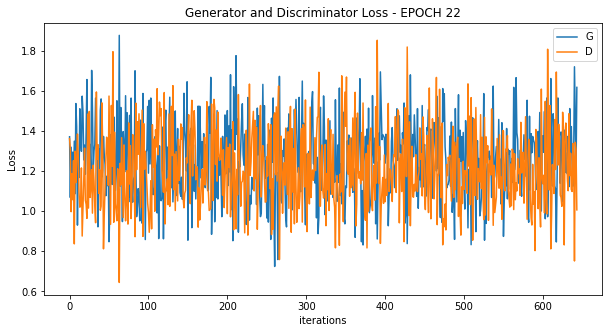

 50%|████▉     | 320/644 [00:20<00:19, 16.67it/s]

[24/100][322/644] Loss_D: 1.4533 Loss_G: 1.0957 D(x): 0.4847 D(G(z)): 0.4005 / 0.4005


100%|█████████▉| 642/644 [00:39<00:00, 17.44it/s]

[24/100][644/644] Loss_D: 0.9792 Loss_G: 1.4712 D(x): 0.5935 D(G(z)): 0.2111 / 0.2111


100%|██████████| 644/644 [00:39<00:00, 16.19it/s]


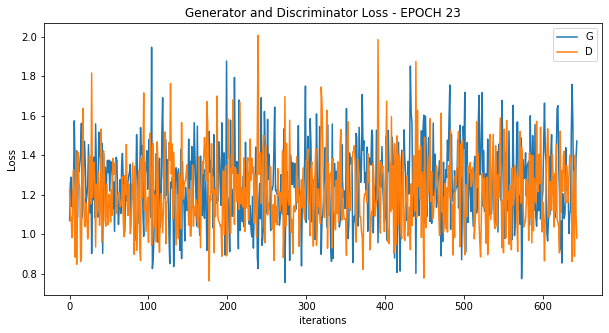

 50%|████▉     | 321/644 [00:20<00:19, 16.77it/s]

[25/100][322/644] Loss_D: 1.4877 Loss_G: 1.2389 D(x): 0.4368 D(G(z)): 0.3411 / 0.3411


100%|█████████▉| 643/644 [00:39<00:00, 17.48it/s]

[25/100][644/644] Loss_D: 0.9177 Loss_G: 2.4475 D(x): 0.4709 D(G(z)): 0.0681 / 0.0681


100%|██████████| 644/644 [00:39<00:00, 16.18it/s]


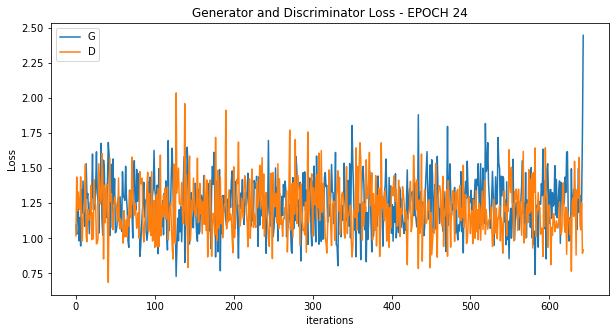

 50%|████▉     | 321/644 [00:19<00:19, 16.60it/s]

[26/100][322/644] Loss_D: 1.1448 Loss_G: 1.1456 D(x): 0.6459 D(G(z)): 0.3698 / 0.3698


100%|█████████▉| 643/644 [00:39<00:00, 15.99it/s]

[26/100][644/644] Loss_D: 1.3701 Loss_G: 1.8410 D(x): 0.3820 D(G(z)): 0.1446 / 0.1446


100%|██████████| 644/644 [00:40<00:00, 16.07it/s]


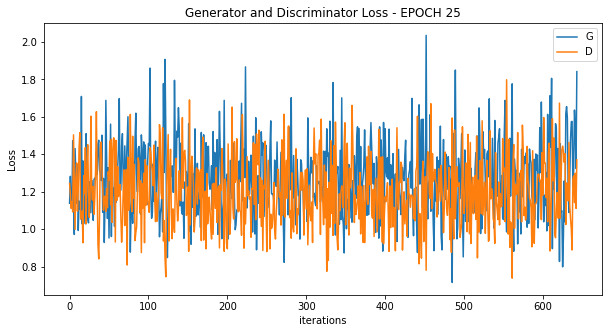

 50%|████▉     | 321/644 [00:20<00:19, 16.20it/s]

[27/100][322/644] Loss_D: 1.2892 Loss_G: 0.9982 D(x): 0.6339 D(G(z)): 0.4403 / 0.4403


100%|█████████▉| 643/644 [00:40<00:00, 16.25it/s]

[27/100][644/644] Loss_D: 0.3961 Loss_G: 3.6965 D(x): 0.7925 D(G(z)): 0.0231 / 0.0231


100%|██████████| 644/644 [00:40<00:00, 15.98it/s]


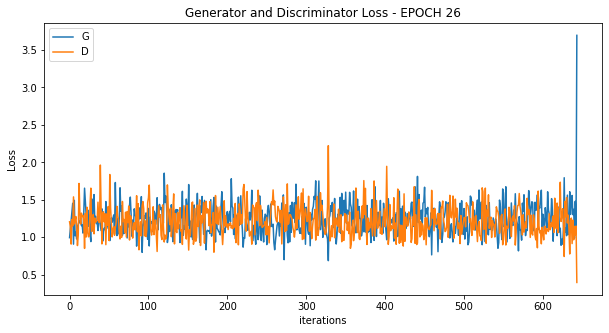

 50%|████▉     | 321/644 [00:20<00:21, 15.29it/s]

[28/100][322/644] Loss_D: 1.2773 Loss_G: 1.2285 D(x): 0.5284 D(G(z)): 0.3710 / 0.3710


100%|█████████▉| 643/644 [00:40<00:00, 17.27it/s]

[28/100][644/644] Loss_D: 1.7028 Loss_G: 0.8549 D(x): 0.4722 D(G(z)): 0.4955 / 0.4955


100%|██████████| 644/644 [00:41<00:00, 15.69it/s]


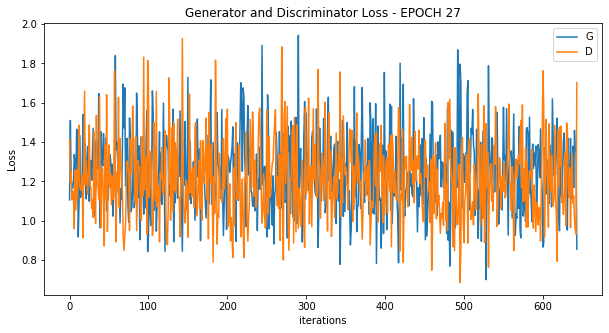

 50%|████▉     | 321/644 [00:19<00:19, 16.56it/s]

[29/100][322/644] Loss_D: 1.1359 Loss_G: 1.0691 D(x): 0.7426 D(G(z)): 0.4203 / 0.4203


100%|█████████▉| 643/644 [00:39<00:00, 16.46it/s]

[29/100][644/644] Loss_D: 1.7767 Loss_G: 2.2617 D(x): 0.2690 D(G(z)): 0.1012 / 0.1012


100%|██████████| 644/644 [00:39<00:00, 16.27it/s]


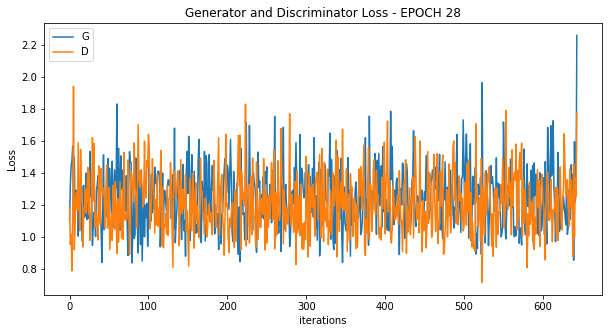

 50%|████▉     | 321/644 [00:20<00:20, 16.02it/s]

[30/100][322/644] Loss_D: 1.1680 Loss_G: 1.0579 D(x): 0.7131 D(G(z)): 0.4112 / 0.4112


100%|█████████▉| 643/644 [00:40<00:00, 17.40it/s]

[30/100][644/644] Loss_D: 0.9671 Loss_G: 1.4307 D(x): 0.5714 D(G(z)): 0.2595 / 0.2595


100%|██████████| 644/644 [00:40<00:00, 15.92it/s]


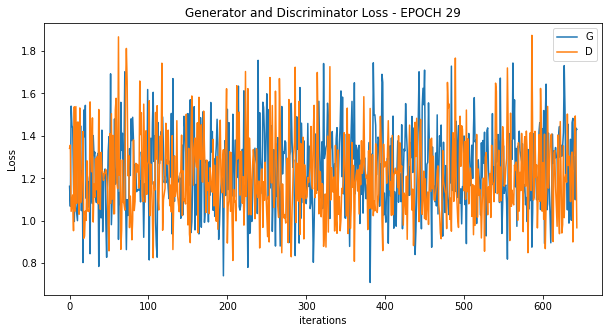

 50%|████▉     | 321/644 [00:19<00:19, 16.27it/s]

[31/100][322/644] Loss_D: 1.1970 Loss_G: 1.1008 D(x): 0.7110 D(G(z)): 0.4010 / 0.4010


100%|█████████▉| 643/644 [00:39<00:00, 16.06it/s]

[31/100][644/644] Loss_D: 1.7592 Loss_G: 1.7526 D(x): 0.2349 D(G(z)): 0.1650 / 0.1650


100%|██████████| 644/644 [00:39<00:00, 16.30it/s]


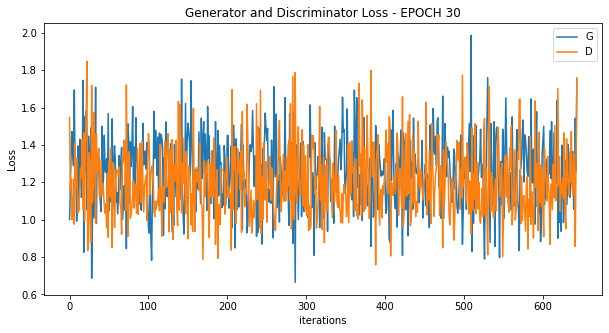

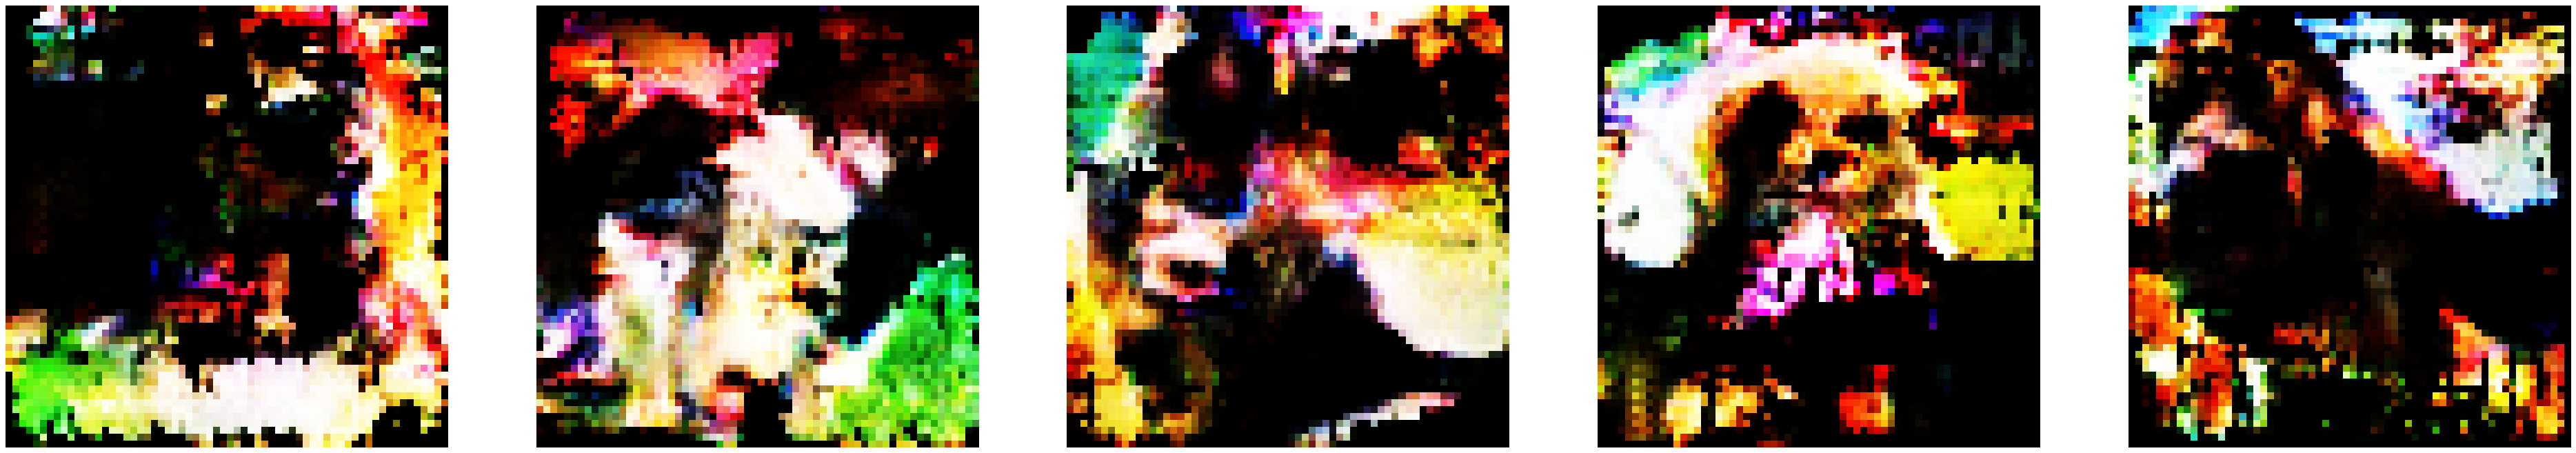

KeyboardInterrupt: 

In [14]:
netG=torch.load(root_dir+'models/generator.pth')
netD=torch.load(root_dir+'models/discriminator.pth')
G_losses = []
D_losses = []

dataloader = DataLoader(dataset, shuffle=True,batch_size=BATCH_SIZE,num_workers=8)
for epoch in range(epochs):

        start = time.time()
        for ii, (real_images, train_labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            labels = torch.full((batch_size, 1), real_label, device=device)

            output = netD(real_images)
            errD_real = criterion(output, labels)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            labels.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, labels)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            labels.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            errG = criterion(output, labels)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            if (ii+1) % (len(dataloader)//2) == 0:
                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                      % (epoch + 1, epochs, ii+1, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        plot_loss (G_losses, D_losses, epoch)
        G_losses = []
        D_losses = []
        if epoch % 10 == 0:
            show_generated_img()
    
            


In [ ]:
torch.save(netG, 'generator.pth')
torch.save(netD, 'discriminator.pth')

In [ ]:
netG = torch.load('./models/generator.pth')
netD = torch.load('./models/discriminator.pth')

In [ ]:
show_generated_img(4)
